In [ ]:
import sys
import os
from dotenv import load_dotenv

default_config_file = os.path.abspath("/mnt/c/Users/Vedank/Documents/Project/Transformer/config.env")
config_file = default_config_file

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text
import random
import nltk.translate.bleu_score as bleu
from tqdm import tqdm

2025-04-07 04:23:07.215717: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 04:23:07.392312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743999787.463566     637 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743999787.483108     637 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 04:23:07.652164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# from tensorflow.keras.mixed_precision import set_global_policy
# set_global_policy('mixed_float16')

In [4]:
print(f"Configuration file: {config_file}\n")

Configuration file: /mnt/c/Users/Sohum/Documents/Project/Transformer/config.env



In [5]:
load_dotenv("config.env")

True

In [6]:
MODEL_NAME = os.getenv('MODEL_NAME')
path_to_target = os.path.abspath(os.environ['TARGET_DATA_PATH'])
path_to_context = os.path.abspath(os.environ['CONTEXT_DATA_PATH'])
model_dir = os.path.abspath(MODEL_NAME)

In [7]:
os.environ['MODEL_PATH']=model_dir

In [8]:
context_vocab_path=os.path.abspath(os.environ['CONTEXT_TOKEN_PATH'])
target_vocab_path=os.path.abspath(os.environ['TARGET_TOKEN_PATH'])

In [9]:
print("Model Name:",MODEL_NAME)
print("Context Dataset:",path_to_context)
print("Target Dataset:",path_to_target)
print("Context Vocab:",context_vocab_path)
print("Target Vocab:",target_vocab_path)
print()

Model Name: TRANS_BASE_EK
Context Dataset: /mnt/c/Users/Sohum/Documents/Transformer/column1.txt
Target Dataset: /mnt/c/Users/Sohum/Documents/Transformer/column2.txt
Context Vocab: /mnt/c/Users/Sohum/Documents/Transformer/column1.txt.vocab
Target Vocab: /mnt/c/Users/Sohum/Documents/Transformer/column2.txt.vocab



In [10]:
os.makedirs(model_dir,exist_ok=True)

In [11]:
BATCH_SIZE = int(os.environ['BATCH_SIZE']) if 'BATCH_SIZE' in os.environ else 64
MAX_TOKENS = int(os.environ['MAX_TOKENS']) if 'MAX_TOKENS' in os.environ else 128

num_layers = int(os.environ['NUM_LAYERS']) if 'NUM_LAYERS' in os.environ else 4
d_model = int(os.environ['D_MODEL']) if 'D_MODEL' in os.environ else 128
dff = int(os.environ['DFF']) if 'DFF' in os.environ else 512
num_heads = int(os.environ['NUM_HEADS']) if 'NUM_HEADS' in os.environ else 8
dropout_rate = float(os.environ['DROPOUT_RATE']) if 'DROPOUT_RATE' in os.environ else 0.1

In [12]:
print("Model configurations\n")
print("Batch size:",BATCH_SIZE)
print("Maximum Token length:",MAX_TOKENS)
print("Number of layers (encoder and decoder):",num_layers)
print("Dimensionality of the embeddings",d_model)
print("Internal dimensionality of the FeedForward layer:",dff)
print("Number of self-attention heads",num_heads)
print("Dropout rate",dropout_rate)
print()

Model configurations

Batch size: 32
Maximum Token length: 64
Number of layers (encoder and decoder): 6
Dimensionality of the embeddings 256
Internal dimensionality of the FeedForward layer: 1024
Number of self-attention heads 4
Dropout rate 0.2



In [13]:
epochs = int(os.environ['epochs']) if 'epochs' in os.environ and int(os.environ['epochs']) >=1 else 10
save_freq = int(os.environ['save_freq']) if 'save_freq' in os.environ and int(os.environ['save_freq']) >1 else 'epoch'

In [14]:
save_weights_only = True
save_best_only = False if os.environ.get("save_best_only") in ['False','false','FALSE'] else True

In [15]:
print("Training Parameters\n")
print("Epochs:",epochs)
print("save_weights_only:",save_weights_only)
print("save_best_only:",save_best_only)
print("save_freq:",save_freq)
print()

Training Parameters

Epochs: 2
save_weights_only: True
save_best_only: True
save_freq: epoch



In [16]:
# Define a callback to save checkpoints
if save_best_only == False:
  if save_weights_only == True:
    checkpoint_filepath = os.path.join(model_dir,'checkpoints/weights.{epoch:02d}-{val_loss:.4f}.h5')
  else:
    checkpoint_filepath = os.path.join(model_dir,'checkpoints/model.{epoch:02d}-{val_loss:.4f}.h5')
elif save_weights_only == False:
  checkpoint_filepath = os.path.join(model_dir,'checkpoints/best_model.h5')
else:
  checkpoint_filepath = os.path.join(model_dir,'checkpoints/best_model.weights.h5')

In [17]:
os.makedirs(os.path.join(model_dir,'checkpoints'), exist_ok=True)

In [18]:
print("Checkpoint path:",checkpoint_filepath)
print()

Checkpoint path: /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/checkpoints/best_model.weights.h5



In [19]:
pretrained_weights = os.path.abspath(os.environ['WEIGHTS_PATH']) if 'WEIGHTS_PATH' in os.environ and os.environ['WEIGHTS_PATH'].lower() not in ['none','n',''] else None
print("Pretrained weights:",pretrained_weights)
print()

Pretrained weights: /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/checkpoints/checkpoint.weights.h5



In [20]:
#load corpus from text file into a numpy list
def load_data(path):

    with open(path, encoding='utf-8') as file:
        lines = file.readlines()

        len_data=len(lines)
        context = np.empty(shape=len_data,dtype=object)
        i=0
        for line in lines:
            context[i] = line.strip()
            i+=1
    del lines
    return context

In [21]:
#splits corpus into 2 parts of specified ratio
def split_corpus(context_full_raw,target_full_raw,ratio):
  is_train_val = np.random.uniform(size=(len(target_full_raw),)) < ratio

  context_test = context_full_raw[~is_train_val]
  target_test = target_full_raw[~is_train_val]
  context_data = context_full_raw[is_train_val]
  target_data = target_full_raw[is_train_val]

  NUM_SAMPLES = len(context_data)
  NUM_SAMPLES_0 = len(context_test)

  return context_data,target_data,context_test,target_test,NUM_SAMPLES,NUM_SAMPLES_0

In [22]:
#save test/train data to file
def save_corpus_to_file(model_dir,source_filename,target_filename,context,target):
  with open(os.path.join(model_dir,source_filename),'w',encoding='utf-8') as src:
      for src_line in context.tolist():
        src.write(src_line+'\n')

  with open(os.path.join(model_dir,target_filename),'w',encoding='utf-8') as trg:
      for trg_line in target.tolist():
        trg.write(trg_line+'\n')
  print(os.listdir(model_dir))

In [23]:
#shuffle dataset
def shuffle_corpus(context,target):

  zipped = list(zip(context, target))
  random.shuffle(zipped)
  context,target = list(zip(*zipped))

  return np.array(list(context)),np.array(list(target))

In [24]:
target_full_raw = load_data(path_to_target)
context_full_raw = load_data(path_to_context)


In [25]:
#split corpus to train and test
context_data,target_data,context_test,target_test,num_train_val_samples,num_test_samples = split_corpus(context_full_raw,target_full_raw,0.85)
print("length test:",num_test_samples)

length test: 20204


In [26]:
#split train data to train and validation
context_train,target_train,context_val,target_val,num_train_samples,num_val_samples = split_corpus(context_data,target_data,0.85)
print("length train:",num_train_samples)
print("length validation:",num_val_samples)

print("Context train[:5]\n",context_train[:5])
print("Target train[:5]\n",target_train[:5])
print()


length train: 97367
length validation: 17338
Context train[:5]
 ['Give three tips for staying healthy.'
 'What are the three primary colors?' 'Describe the structure of an atom.'
 'How can we reduce air pollution?'
 'Write a concise summary of the following: "Commodore 64 (commonly known as the C64 or CBM 64) was manufactured by Commodore Business Machine (CBM) in August 1982 with a starting price of $595. It was an 8-bit home computer with remarkable market success. Between 1983-1986, C64 sales amounted to about 17 million units sold, making them the best-selling single personal computer model of all time in 1983-1986. Additionally, the Commodore 64 dominated the market with between 30% and 40% share and 2 million units sold per year, outselling the IBM PC clones, Apple Computers, and Atari computers. Adding to their success, Sam Tramiel (former Atari president), during an interview in 1989, said they were building 400,000 C64s a month for a couple of years. "']
Target train[:5]
 ['नि

In [27]:
#save validation data to file
save_corpus_to_file(model_dir,"src.val.txt","trg.val.txt",context_val,target_val)
#save test data to file
save_corpus_to_file(model_dir,"src.test.txt","trg.test.txt",context_test,target_test)

['checkpoints', 'src.test.txt', 'src.val.txt', 'trg.test.txt', 'trg.val.txt']
['checkpoints', 'src.test.txt', 'src.val.txt', 'trg.test.txt', 'trg.val.txt']


In [28]:
BUFFER_SIZE = num_train_samples

train_examples = (
    tf.data.Dataset
    .from_tensor_slices((context_train, target_train))
    .shuffle(BUFFER_SIZE)
    )
val_examples = (
    tf.data.Dataset
    .from_tensor_slices((context_val, target_val))
    .shuffle(BUFFER_SIZE)
    )

I0000 00:00:1743999802.932554     637 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [29]:
#convert context and target dataset to tensor
full_context = tf.data.Dataset.from_tensor_slices(context_full_raw)
full_target = tf.data.Dataset.from_tensor_slices(target_full_raw)

In [30]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

bert_tokenizer_params=dict(lower_case=False)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 100000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [31]:
#open the english and konkani vocabulary
context_vocab = load_data(context_vocab_path)
target_vocab = load_data(target_vocab_path)
context_vocab_size = len(context_vocab)
target_vocab_size = len(target_vocab)

In [32]:
print("Length of Context vocab:",context_vocab_size)
print("Examples:")
print(context_vocab[:10])
print(context_vocab[100:110])
print()
print("length of Target vocab:",target_vocab_size)
print("Examples:")
print(target_vocab[:10])
print(target_vocab[100:110])
print()

Length of Context vocab: 25193
Examples:
['[PAD]' '[UNK]' '[START]' '[END]' '!' '"' '#' '$' '%' '&']
['½' '×' 'á' 'ç' 'é' 'í' 'ï' 'ö' '÷' 'ā']

length of Target vocab: 33593
Examples:
['[PAD]' '[UNK]' '[START]' '[END]' '!' '"' '#' '$' '%' '&']
['÷' '˚' 'ँ' 'ं' 'ः' 'अ' 'आ' 'इ' 'ई' 'उ']



In [33]:
context_tokenizer = tensorflow_text.BertTokenizer(context_vocab_path, **bert_tokenizer_params)
target_tokenizer = tensorflow_text.BertTokenizer(target_vocab_path, **bert_tokenizer_params)

In [34]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")


In [35]:
def add_start_end(ragged):
    count = ragged.bounding_shape()[0]
    starts = tf.fill([count,1], START)
    ends = tf.fill([count,1], END)
    return tf.concat([starts, ragged, ends], axis=1)

In [36]:
def tokenize(inputs,tokenizer):
    token_batch = tokenizer.tokenize(inputs)
    token_batch = token_batch.merge_dims(-2,-1)
    return add_start_end(token_batch)

In [37]:
def prepare_batch(ct, tg):

    ct = tokenize(ct,context_tokenizer)
    ct = ct[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    ct = ct.to_tensor()  # Convert to 0-padded dense Tensor

    tg = tokenize(tg,target_tokenizer)
    tg = tg[:, :(MAX_TOKENS+1)]
    tg_inputs = tg[:, :-1].to_tensor()  # Drop the [END] tokens
    tg_labels = tg[:, 1:].to_tensor()   # Drop the [START] tokens

    return (ct, tg_inputs), tg_labels

In [38]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [39]:

# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

for (ct, tg), tg_labels in train_batches.take(1):
  break

print("Shape Target:",tg.shape)
print("Shape Target labels:",tg_labels.shape)

2025-04-07 04:23:25.653210: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT64 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Shape Target: (32, 64)
Shape Target labels: (32, 64)


In [40]:
print("\nDefining the components:")

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)


Defining the components:


In [41]:
pos_encoding = positional_encoding(length=1024, depth=256)

# Check the shape.
print("Shape Positional encoding:",pos_encoding.shape)


Shape Positional encoding: (1024, 256)


In [42]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [43]:
embed_context = PositionalEmbedding(vocab_size=context_vocab_size, d_model=512)
embed_target = PositionalEmbedding(vocab_size=target_vocab_size, d_model=512)

context_emb = embed_context(ct)
target_emb = embed_target(tg)

In [44]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [45]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [46]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print("Shape context embedding:",context_emb.shape)
print("Target context embedding:",target_emb.shape)
print("Shape sample CrossAttention:",sample_ca(target_emb, context_emb).shape)


Shape context embedding: (32, 64, 512)
Target context embedding: (32, 64, 512)
Shape sample CrossAttention: (32, 64, 512)


In [47]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [48]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print("Shape context embedding",context_emb.shape)
print("Shape sample GlobalSelfAttention",sample_gsa(context_emb).shape)


Shape context embedding (32, 64, 512)
Shape sample GlobalSelfAttention (32, 64, 512)


In [49]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [50]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print("Shape Traget Embedding:",target_emb.shape)
print("Shape sample CausalSelfAttention:",sample_csa(target_emb).shape)


Shape Traget Embedding: (32, 64, 512)
Shape sample CausalSelfAttention: (32, 64, 512)


In [51]:
out1 = sample_csa(embed_target(tg[:, :3]))
out2 = sample_csa(embed_target(tg))[:, :3]
tf.reduce_max(abs(out1 - out2)).numpy()

/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


np.float32(0.00012660027)

In [52]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [53]:
sample_ffn = FeedForward(512, 2048)

print("Shape Target Embedding:",target_emb.shape)
print("Shape Sample FFN:",sample_ffn(target_emb).shape)

Shape Target Embedding: (32, 64, 512)
Shape Sample FFN: (32, 64, 512)


In [54]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [55]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print("Shape context Embedding:",context_emb.shape)
print("Shape sample encoder layer:",sample_encoder_layer(context_emb).shape)


Shape context Embedding: (32, 64, 512)
Shape sample encoder layer: (32, 64, 512)


In [56]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [57]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=num_layers,
                         d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         vocab_size=context_vocab_size)

sample_encoder_output = sample_encoder(ct, training=False)

# Print the shape.
print("Context shape",ct.shape)
print("Shape sample_encoder_output",sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.


Context shape (32, 64)
Shape sample_encoder_output (32, 64, 256)


/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [58]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [59]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=target_emb, context=context_emb)

print(target_emb.shape)
print(context_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`


(32, 64, 512)
(32, 64, 512)
(32, 64, 512)


In [60]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [61]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=num_layers,
                         d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         vocab_size=target_vocab_size)

output = sample_decoder(x=tg,context=context_emb)

# Print the shapes.
print("Shape target:",tg.shape)
print("Shape Context embedding:",context_emb.shape)
print("Shape sample decoder:",output.shape)

sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

Shape target: (32, 64)
Shape Context embedding: (32, 64, 512)
Shape sample decoder: (32, 64, 256)


/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


TensorShape([32, 4, 64, 64])

In [62]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


In [63]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=context_vocab_size,
    target_vocab_size=target_vocab_size,
    dropout_rate=dropout_rate)

In [64]:
output = transformer((ct, tg))

print(tg.shape)
print(ct.shape)
print(output.shape)

attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)

/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_8' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_7' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_8' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore de

(32, 64)
(32, 64)
(32, 64, 33593)
(32, 4, 64, 64)


In [65]:
transformer.summary()


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Encoder)             │ ?                      │    15,920,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │    24,385,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (32, 64, 33593)        │     8,633,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,939,065 (186.69 MB)

 Trainable params: 48,939,065 (186.69 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    d_model = d_model
    warmup_steps = warmup_steps

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {
        "d_model": float(self.d_model),
        "warmup_steps": float(self.warmup_steps),
    }

  @classmethod
  def from_config(cls, config):
      return cls(**config)

In [67]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [68]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

In [69]:
def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [70]:
# # Define checkpoint callback with explicit model reference
# checkpoint_filepath = f"{model_dir}/checkpoints/checkpoint.weights.h5"  # Example filepath
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_loss',           # Metric to monitor
#     save_best_only=True,          # Save only the best model
#     save_weights_only=True,       # Save only weights (not full model)
#     mode='min',                   # Minimize val_loss
#     save_freq='epoch'             # Save every epoch
# )

In [71]:
if pretrained_weights != None:
  print(f"Loading pretrained weights from {pretrained_weights}")
  transformer.load_weights(pretrained_weights)

Loading pretrained weights from /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/checkpoints/checkpoint.weights.h5


In [72]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [73]:
# transformer.fit(train_batches,
#                 epochs=epochs,
#                 validation_data=val_batches,
#                 callbacks=[checkpoint_callback]
#                 )

In [74]:
# Define the effective batch size you want to simulate
EFFECTIVE_BATCH_SIZE = 128  # Adjust this based on your needs
ACCUMULATION_STEPS = EFFECTIVE_BATCH_SIZE // BATCH_SIZE  # Number of steps to accumulate gradients

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
masked_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='masked_accuracy')

# Custom training loop with gradient accumulation
@tf.function
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = transformer(inputs, training=True)
        loss = loss_fn(targets, predictions)
        # Apply masking for padded tokens (assuming your model handles this)
        mask = tf.cast(targets != 0, tf.float32)
        loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    return loss, gradients

# Define checkpoint filepath (no need for ModelCheckpoint object)
checkpoint_filepath = f"{model_dir}/checkpoints/checkpoint.weights.h5"

# Lists to store metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Custom training loop with progress bar and metrics saving
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    # Training
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = masked_accuracy
    accumulated_gradients = [tf.zeros_like(var) for var in transformer.trainable_variables]
    step_count = 0
    
    # Calculate total number of batches for progress bar
    total_batches = tf.data.experimental.cardinality(train_batches).numpy()
    if total_batches < 0:  # If cardinality is unknown, estimate or set a default
        total_batches = len(list(train_batches))  # This might be slow; use with caution
    
    # Training loop with progress bar
    with tqdm(total=total_batches, desc=f"Epoch {epoch + 1} Training", unit="batch") as pbar:
        for batch_idx, ((ct, tg_inputs), tg_labels) in enumerate(train_batches):
            loss, gradients = train_step((ct, tg_inputs), tg_labels)
            
            # Accumulate gradients
            accumulated_gradients = [acc_grad + grad for acc_grad, grad in zip(accumulated_gradients, gradients)]
            step_count += 1
            
            # Update weights when accumulation steps are reached
            if step_count % ACCUMULATION_STEPS == 0:
                optimizer.apply_gradients(zip(accumulated_gradients, transformer.trainable_variables))
                accumulated_gradients = [tf.zeros_like(var) for var in transformer.trainable_variables]
                step_count = 0
            
            train_loss.update_state(loss)
            train_accuracy.update_state(tg_labels, transformer([ct, tg_inputs], training=True))
            
            # Update progress bar with current loss and accuracy
            if batch_idx % 100 == 0:
                pbar.set_postfix({'loss': f"{train_loss.result():.4f}", 'acc': f"{train_accuracy.result():.4f}"})
            pbar.update(1)
    
    # Apply remaining gradients if any
    if step_count > 0:
        optimizer.apply_gradients(zip(accumulated_gradients, transformer.trainable_variables))
    
    # Validation
    val_loss = tf.keras.metrics.Mean(name='val_loss')
    val_accuracy = masked_accuracy
    
    # Calculate total validation batches for progress bar
    total_val_batches = tf.data.experimental.cardinality(val_batches).numpy()
    if total_val_batches < 0:
        total_val_batches = len(list(val_batches))  # Estimate if unknown
    
    with tqdm(total=total_val_batches, desc=f"Epoch {epoch + 1} Validation", unit="batch") as pbar:
        for batch_idx, ((ct, tg_inputs), tg_labels) in enumerate(val_batches):
            predictions = transformer([ct, tg_inputs], training=False)
            loss = loss_fn(tg_labels, predictions)
            mask = tf.cast(tg_labels != 0, tf.float32)
            loss = tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)
            val_loss.update_state(loss)
            val_accuracy.update_state(tg_labels, predictions)
            pbar.set_postfix({'val_loss': f"{val_loss.result():.4f}", 'val_acc': f"{val_accuracy.result():.4f}"})
            pbar.update(1)
    
    # Store metrics for plotting
    train_losses.append(train_loss.result().numpy())
    train_accuracies.append(train_accuracy.result().numpy())
    val_losses.append(val_loss.result().numpy())
    val_accuracies.append(val_accuracy.result().numpy())
    
    # Print epoch results
    print(f"Epoch {epoch + 1} - Loss: {train_loss.result():.4f}, Accuracy: {train_accuracy.result():.4f}, "
          f"Val Loss: {val_loss.result():.4f}, Val Accuracy: {val_accuracy.result():.4f}")
    
    # Manual checkpoint saving logic
    current_val_loss = val_loss.result().numpy()
    if 'best_val_loss' not in locals() or current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        transformer.save_weights(checkpoint_filepath, overwrite=True)
        print(f"Saved weights to {checkpoint_filepath} with val_loss: {current_val_loss:.4f}")

Epoch 1/2


Epoch 1 Validation: 100%|██████████| 542/542 [01:46<00:00,  5.07batch/s, val_loss=0.5472, val_acc=0.8914]


Epoch 1 - Loss: 0.5595, Accuracy: 0.8914, Val Loss: 0.5472, Val Accuracy: 0.8914
Saved weights to /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/checkpoints/checkpoint.weights.h5 with val_loss: 0.5472
Epoch 2/2


Epoch 2 Validation: 100%|██████████| 542/542 [01:45<00:00,  5.12batch/s, val_loss=0.5992, val_acc=0.8955]

Epoch 2 - Loss: 0.4989, Accuracy: 0.8955, Val Loss: 0.5992, Val Accuracy: 0.8955


Training metrics saved to /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/training_metrics.txt
Plots saved to /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/training_plots.png


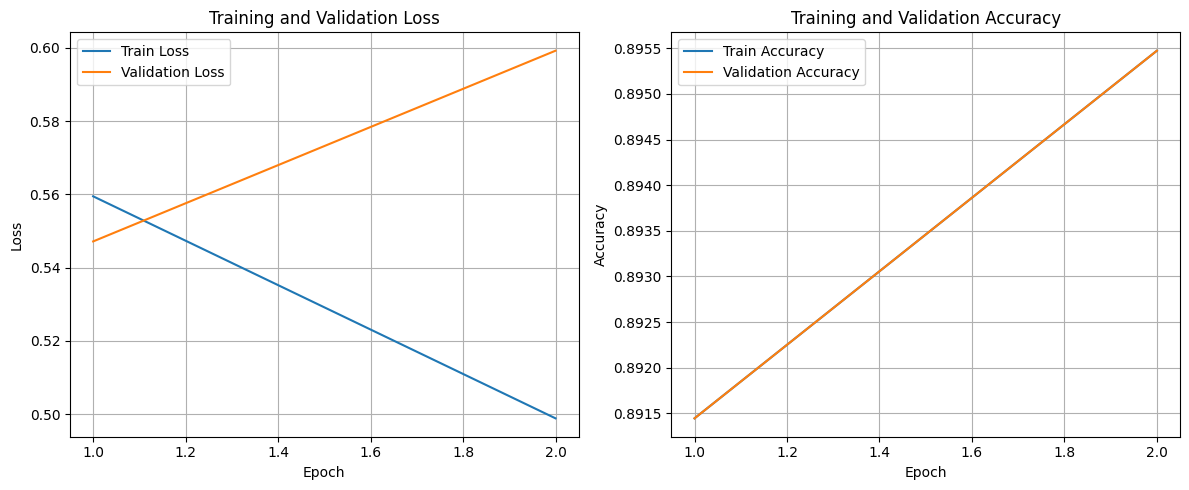

In [75]:
# After training, save metrics to a file
metrics_filepath = os.path.join(model_dir, "training_metrics.txt")
with open(metrics_filepath, 'w') as f:
    f.write("Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy\n")
    for i in range(epochs):
        f.write(f"{i+1},{train_losses[i]},{train_accuracies[i]},{val_losses[i]},{val_accuracies[i]}\n")
print(f"Training metrics saved to {metrics_filepath}")

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Save the plot
plot_filepath = os.path.join(model_dir, "training_plots.png")
plt.tight_layout()
plt.savefig(plot_filepath)
print(f"Plots saved to {plot_filepath}")

# Display the plot (optional, remove if running in a non-interactive environment)
plt.show()

In [76]:
#save the model architecture
transformer.export(filepath=f'{model_dir}/saved_keras')

INFO:tensorflow:Assets written to: /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/saved_keras/assets


INFO:tensorflow:Assets written to: /mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/saved_keras/assets


Saved artifact at '/mnt/c/Users/Sohum/Documents/Transformer/TRANS_BASE_EK/saved_keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64), dtype=tf.float32, name=None)]
Output Type:
  TensorSpec(shape=(None, 64, 33593), dtype=tf.float32, name=None)
Captures:
  139893895510320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139893894315696: TensorSpec(shape=(2048, 256), dtype=tf.float32, name=None)
  139899711328672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139895207518448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139893888136992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139893891056032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139894131577600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139893893966832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139893887949984: TensorSpec(shape=(), dty

In [77]:
#load the best weights
if (save_weights_only == True and save_best_only == True):
  transformer.load_weights(checkpoint_filepath)

In [78]:
class Translator(tf.Module):
  def __init__(self, context_tokenizers, target_tokenizers, transformer):
    self.context_tokenizers = context_tokenizers
    self.target_tokenizers = target_tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS): #max_length=MAX_TOKENS
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = tokenize(sentence,self.context_tokenizers).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.

    start_end = tokenize('',self.target_tokenizers)[0]
    start = start_end[0][tf.newaxis]
    end = start_end[-1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.

    text = self.target_tokenizers.detokenize(output)

    tokens = tf.gather(target_vocab, output)

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    joined_text = tf.strings.reduce_join(text[0][1:-1], separator=' ', axis=-1)
    return joined_text, tokens, attention_weights


In [79]:
translator = Translator(context_tokenizer, target_tokenizer, transformer)
print("Translator object created!")

Translator object created!


In [80]:

print("Building the ExportTranslator class...")

class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

Building the ExportTranslator class...


In [81]:
exp_translator = ExportTranslator(translator)

print("\nTesting inputs (test)....")

for i in range(10,15):
  print("Input:",context_test[i])
  print("Expected:",target_test[i])
  print("Output:",exp_translator(context_test[i]).numpy().decode())
  print()

print("\nTesting inputs (train)....")

for i in range(10,15):
  print("Input:",context_train[i])
  print("Expected:",target_train[i])
  print("Output:",exp_translator(context_train[i]).numpy().decode())
  print()


Testing inputs (test)....
Input: Generate a creative birthday wish for a friend.
Expected: इश्टा खातीर सर्जनशील वाडदिसाची इत्सा निर्माण करात.


/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_8' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_7' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/sohum12/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_8' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore de

Output: इश्टा खातीर एक सर्जनशील वाडदिसाची इत्सा निर्माण करप . इश्टा खातीर एक सर्जनशील वाडदिसाची इत्सा तयार करप .

Input: Compile a list of 5 US states located in the Mid West.
Expected: मध्य अस्तंत वाठारांत आशिल्ल्या अमेरिकेच्या 5 राज्यांची वळेरी तयार करात.
Output: मध्य अस्तंत वाठारांत आशिल्ल्या अमेरिकेच्या 5 अमेरिकेच्या राज्यांची वळेरी तयार करात .

Input: Design a post for a social media account to promote the following product
Expected: सकयल दिल्ल्या उत्पादनाचो प्रचार करपा खातीर सोशल मिडिया खात्या खातीर पोस्ट डिझायन कर
Output: सकयल दिल्ल्या उत्पादनाक चालना दिवपा खातीर सोशल मिडिया खात्या खातीर पोस्ट तयार करात . सकयल दिल्ल्या उत्पादनाचो प्रचार करपा खातीर सोशल मिडिया खात्या खातीर पोस्ट तयार करात . सोशल मिडिया खात्या खातीर पोस्ट तयार करात , सोशल मिडिया खात्या खातीर पोस्ट तयार करात

Input: Describe the sound of the given object.
Expected: दिल्ल्या वस्तूच्या आवाजाचें वर्णन करप.
Output: दिल्ल्या वस्तूच्या आवाजाचें वर्णन दिल्ल्या वस्तूचें वर्णन करप .

Input: Generate a pitch for a new and or

In [82]:
def calc_bleu_score(context_test,target_test):
    # Calculate the BLEU score
    references = []
    translations = []
    count=1

    final_test = context_test

    print("Translatating ...")

    for chunk in final_test:
      predicted_translation = exp_translator(chunk)
      #print(count)
      count+=1
      translations.append(predicted_translation.numpy().decode().split())

    for t in target_test:
      references.append([t.split()])

    print("\nTranslations completed! working on blue scores ...")

    # Calculate the BLEU score
    bleu4_score = bleu.corpus_bleu(references, translations)
    bleu3_score = bleu.corpus_bleu(references, translations,weights=(0.33, 0.33, 0.33, 0))
    bleu2_score = bleu.corpus_bleu(references, translations,weights=(0.5, 0.5, 0, 0))
    bleu_score = bleu.corpus_bleu(references, translations,weights=(1, 0, 0, 0))

    return bleu_score,bleu2_score,bleu3_score,bleu4_score

In [83]:
context_bleu,target_bleu = shuffle_corpus(context_test,target_test)

#calculate blue score on test data
print("\nCalculating bleu score...")
bleu_score,bleu2_score,bleu3_score,bleu4_score = calc_bleu_score(context_bleu[:3000],target_bleu[:3000])
print("Bleu1 score:",bleu_score)
print("Bleu2 score:",bleu2_score)
print("Bleu3 score:",bleu3_score)
print("Bleu4 score:",bleu4_score)

import datetime
current_time = datetime.datetime.now()

#write result to file
with open(f"{model_dir}/bleu_score.txt",'w') as eval_file:
  eval_file.write(f"Time:{current_time}\n")
  eval_file.write(f"BLEU1 SCORE: {bleu_score}\n")
  eval_file.write(f"BLEU2 SCORE: {bleu2_score}\n")
  eval_file.write(f"BLEU3 SCORE: {bleu3_score}\n")
  eval_file.write(f"BLEU4 SCORE: {bleu4_score}\n\n")

print("\nExecution finished!")


Calculating bleu score...
Translatating ...

Translations completed! working on blue scores ...
Bleu1 score: 0.21133930627669792
Bleu2 score: 0.14682896028272724
Bleu3 score: 0.11053620548018843
Bleu4 score: 0.08323015794547889

Execution finished!
